## <center>卷积神经网络</center>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import os
# gpu_no = '0'
# os.environ["CUDA_VISIBLE_DEVICES"] = gpu_no
# # 定义TensorFlow配置
# config = tf.ConfigProto()
# # 配置GPU内存分配方式，按需增长，很关键
# config.gpu_options.allow_growth = True
# # 配置可使用的显存比例
# config.gpu_options.per_process_gpu_memory_fraction = 1
# # 在创建session的时候把config作为参数传进去
# sess = tf.Session(config = config)
sess = tf.Session()

### 1 理解卷积神经网络

卷积神经网络,使用权重共享的方式构建网络,避免了对参数的过度依赖,相比于全连接网络,能更好的识别高维数据. 卷积神经网络的结构主要包括卷积层,池化层.一个卷积神经网络主要包括以下5个部分:

+ 输入层:将每个像素代表一个特征节点输入进来
+ 卷积操作:由多个滤波器组合的卷积层
+ 池化层:将卷积结果降维
+ 全局平均池化层:对生成的feature map 取平均值
+ 输出层:需要分成几个类,相应的就会有几个输出节点.每个输出节点都代表当前样本属于的该类的概率

<font color='red'>注意</font>

全局平均池化层是后出的新技术,以前这个位置通常使用 1-3 层全连接层来替代. 全连接层的劣势在于会产生大量的计算,需要大量的参数,但在效果上却和全局平均池化层一样.

### 2 卷积操作
卷积分为窄卷积,全卷积和同卷积
<center><img src="./img/6/1.png" width="600"></center>

#### (1) 步长

步长通常使用 stride 来表示, 上图中 filter 表示卷积核, 每个卷积核可以输出一个 feature map. stride =1 表示每次移动一步. 卷积操作就是,原图与filter 对应位置直接相乘,再将其结果相加.

#### (2)窄卷积

窄卷积(<font color='red'>valid卷积</font>),生成的feature map 比原始图片小,它的步长是可变的. 假如 滑动的步长为 $S$, 原始图片的维度为 $N_1 \times N_1$, 并且卷积核的大小为 $N_2 \times N_2$ ,那么卷积之后的图像大小为 $floor(\frac{N_1 - N_2}{S}) + 1$

#### (3)同卷积

同卷积(<font color='red'>same卷积</font>),生成的feature map 与原始图片大小相同,它的步长是不变的,滑动步长都是1.一般操作时都需要使用padding技术(外围补一圈0,以确保生成的尺寸不变).

#### (4) 全卷积
全卷积(<font color="red">full 卷积</font>),也叫反卷积.就是把原始图片里的每个像素用卷积操作展开.如图,白色的表示原始的图片,灰色的表示卷积核,黑色的表示正在进行卷积操作的像素.
<center><img src="./img/6/2.png" width="600"/></center>

#### (5)多通道卷积
通道是指图片中每个像素由几个数来表示,例如黑白图片,通道数是1,彩色图片通道数是3,在卷积神经网络中,通道又分为输入通道和输出通道.
+ 输入通道:如果是彩色图片,那么起始输入通道就是3. 如果是中间层的卷积,输入通道就是上一层的输出通道. 计算方法是, <font color="red">每个输入通道</font>的图片都<font color="red">使用同一个卷积核</font>进行卷积操作,生成与输入通道匹配的 feature map (例如,彩色图片就是3个) ,然后再将这几个feature map 相同的位置熵的值加起来,生成一张feature map

+ 输出通道:想要输出几个feature map,就放几个卷积核,这就是输出通道

#### (6) 池化层
池化层的主要目的是降维,即在保持原有特征的基础上,最大限度地将数组的维数变小.池化步骤也有步长,和卷积非常像.
+ **均值池化**: 就是计算在卷积核对应的区域中,<font color='red'>所有不为0的像素点均值</font>,只能计算不为0的点,否则影响结果.
+ **最大池化**: 就是计算在卷积核对应的区域中,选择放最大值.

### 2 卷积神经网络中相关函数

#### (1) 卷积函数
Tensorflow中使用 tf.nn.conv2d 函数来实现卷积,其格式如下:
```python
tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None)

input: 原图像,要求是一个Tensor,形状为 [batch,height,width,channels] 并且数据类型要求是tf.float32 或 tf.float64

filter: 卷积核,要求是一个Tensor,形状为 [height,width,in_channels,out_channels] 要求in_channels和input 的通道数量相同

strides: 步长, strides = [batch , in_height , in_width, in_channels]。其中 batch 和 in_channels 要求一定为1

padding: 定义元素边框与元素内容之间的空间. string 类型的变量,只能是 "SAME" 和 "VALID",这个值决定了不同的卷积方式,padding 的值为 "VALID" 时,表示边缘不填充. 当其填充为 "SAME"时, 表示填充到滤波器可以达到图像边缘.

use_cudnn_on_gpu: bool 类型,是否使用 cudnn 加速,默认为true.

返回值: tf.nn.conv2d 函数结果返回一个Tensor, 这个输出就是常说的 feature map
```

<font color='red'>注意</font>

在卷积函数中,padding 参数是最容易引起歧义的, 该参数仅仅决定是否要补0, 因此一定要清楚, padding 设置为 "SAME" 的真正含义,在设为 SAME 的情况下,只有在步长为 1 时,生成的feature map 才会与输入值相等.

#### (2) padding 规则介绍
padding 属性的意义是定义<font color='red'>边框与元素内容</font>之间的空间.有具体的计算公式:
+ 输入图像中高和宽定义为: in_height, in_width
+ 卷积核中高和宽的定义为: filter_height, filter_width
+ 输出的尺寸中高和宽的定义为: output_height, output_width
+ 步长的高和宽定义为: strides_height, strides_width

**VALID填充**
```python
output_height = ceil((in_height-filter_height +1)/strides_height)
output_width = ceil((in_width - filter_width+1)/strides_width)
```

**SAME填充**
输出的宽和高和卷积核没有关系
```python
output_height = ceil(in_height/strides_height)
output_width = ceil(in_width/strides_width)
```

**补零规则**<font color='red'>(只会发生在SAME填充的情况下)</font>
```python
pad_height = max((out_height-1)*strides_height + filter_height - in_height,0)
pad_width = max((out_width-1)*strides_width + filter_width - in_width,0)

# 当填充数量为奇数时,左边和上边填充数量少一个
pad_top = pad_height/2
pad_bottom = pad_height - pad_top

pad_left = pad_width/2
pad_right = pad_width - pad_left
```

**举例说明**
假设输入一个一维数据,长度是13,filter是6,步长是5

'VALID'填充:生成的宽度为 (13-6+1)/5 = 2 (向上取整)

'SAME'填充:生成的宽度为 13/5 = 3 (向上取整), padding 的计算方式如下:
+ pad_width = max((3-1)*5+6-13,0) = 3
+ pad_left = pad_width/2 = 1
+ pad_right = pad_width - pad_left = 2


### 3 卷积函数的使用

#### (1) 定义输入变量

In [2]:
# 输入的原始图片的形状通常是 [batch,in_height,in_width,in_channels]
input1 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=1.0,shape=[1,5,5,1]))
input2 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=1.0,shape=[1,5,5,2]))
input3 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=1.0,shape=[1,4,4,1]))

#### (2) 定义卷积核变量

In [3]:
# 卷积核的形状通常是 [filter_height,filter_width,in_channels,out_channels]
# tensorflow 系统可以自动将一维的 value 转换成对应的 shape
filter1 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=[-1.,0,0,-1.],
                                                                 shape=[2,2,1,1]))
filter2 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=[-1.,0,0,-1.,
                                                                        -1.,0,0,-1.],
                                                                 shape=[2,2,1,2]))
filter3 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=[-1.,0,0,-1.,
                                                                        -1.,0,0,-1.,
                                                                        -1.,0,0,-1.],
                                                                 shape=[2,2,1,3]))
filter4 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=[-1.,0,0,-1.,
                                                                        -1.,0,0,-1.,
                                                                        -1.,0,0,-1.,
                                                                        -1.,0,0,-1.],
                                                                 shape=[2,2,2,2]))
filter5 = tf.Variable(dtype=tf.float32,initial_value=tf.constant(value=[-1.,0,0,-1.,
                                                                        -1.,0,0,-1.],
                                                                 shape=[2,2,2,1]))

#### (3) 定义卷积操作

In [4]:
# padding 的值为 'VALID', 表示边缘不填充,多余的就会丢弃. 
# 当其为 'SAME'时,如果出现多余的,那么就填充不全,形成一个完整的,如果已经是完整的了,就不会填充

# 1个输入通道,1个输出通道,也就是一个 feature map
op1 = tf.nn.conv2d(input=input1,filter=filter1,strides=[1,2,2,1],padding='SAME')
# 1个输入通道,2个输出通道,也就是两个 feature map
op2 = tf.nn.conv2d(input=input1,filter=filter2,strides=[1,2,2,1],padding='SAME')
# 1个输入通道,3个输出通道,也就是三个 feature map
op3 = tf.nn.conv2d(input=input1,filter=filter3,strides=[1,2,2,1],padding='SAME')
# 2个输入通道,2个输出通道,也就是两个 feature map
op4 = tf.nn.conv2d(input=input2,filter=filter4,strides=[1,2,2,1],padding='SAME')
# 2个输入通道,1个输出通道,也就是一个 feature map
op5 = tf.nn.conv2d(input=input2,filter=filter5,strides=[1,2,2,1],padding='SAME')
# 与op1相比 因为填充不同,结果也不同
op6 = tf.nn.conv2d(input=input1,filter=filter1,strides=[1,2,2,1],padding='VALID')
op7 = tf.nn.conv2d(input=input3,filter=filter1,strides=[1,2,2,1],padding='SAME')
op8 = tf.nn.conv2d(input=input3,filter=filter1,strides=[1,2,2,1],padding='VALID')
sess.run(tf.global_variables_initializer())

+ 对于 op1 输入的 shape = [1,5,5,1], filter 的 shape = [2,2,1,1], strides=[1,2,2,1], 填充方式为 "SAME"

In [5]:
print(sess.run(op1))
print(op1.shape)

[[[[-2.]
   [-2.]
   [-1.]]

  [[-2.]
   [-2.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]]]]
(1, 3, 3, 1)


+ 对于 op2 输入的 shape = [1,5,5,1], filter 的 shape = [2,2,1,2],有两个卷积核,所以会输出两个feature map, strides=[1,2,2,1], 填充方式为 "SAME"

In [6]:
print(sess.run(op2))

[[[[-2. -2.]
   [-2. -2.]
   [-2.  0.]]

  [[-2. -2.]
   [-2. -2.]
   [-2.  0.]]

  [[-1. -1.]
   [-1. -1.]
   [-1.  0.]]]]


+ 对于 op5 输入的 shape = [1,5,5,2], filter 的 shape = [2,2,2,1],输入通道为2,输出通道为1所以会输出1个feature map,这个feature map是由前面两个叠加得到的, strides=[1,2,2,1], 填充方式为 "SAME"
<center><img src='./img/6/3.png' width="600"/></center>

In [7]:
print(sess.run(op5))

[[[[-4.]
   [-4.]
   [-2.]]

  [[-4.]
   [-4.]
   [-2.]]

  [[-2.]
   [-2.]
   [-1.]]]]


### 4 使用卷积提取图片的轮廓

#### (1) 载入图像并显示

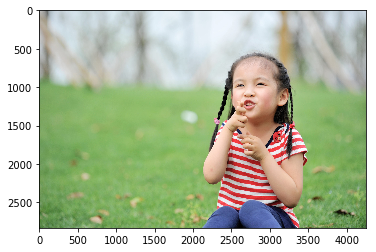

(2832, 4256, 3)


In [8]:
import matplotlib.image as mtimg
myimg = mtimg.imread('./img/6/4.jpg')
plt.imshow(myimg)
plt.show()
print(myimg.shape)

#### (2) 定义占位符,卷积核,卷积op

In [9]:
input_img = tf.Variable(tf.constant(value=1.0,shape=[1,2832,4256,3],dtype=tf.float32))
filter_img = tf.Variable(tf.constant(value=[[-1.,-1.,-1.],[0,0,0],[1.,1.,1.],
                                        [-2.,-2.,-2.],[0,0,0],[2.,2.,2.],
                                        [-1.,-1.,-1.],[0,0,0],[1.,1.,1.]],shape=[3,3,3,1]))
# 输入三个通道,输出一个通道
op = tf.nn.conv2d(input=input_img,filter=filter_img,strides=[1,1,1,1],padding='SAME')
# 最后需要将其归一化,变成一个黑白图像
output = tf.cast(255*(op - tf.reduce_min(op))/(tf.reduce_max(op)-tf.reduce_min(op)),dtype=tf.int32)

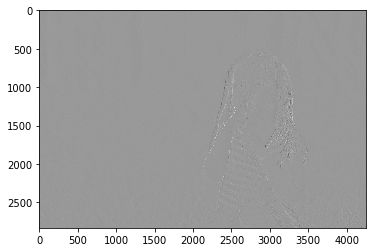

In [10]:
sess.run(tf.global_variables_initializer())
img = np.reshape(myimg,newshape=[1,2832,4256,3])
out = sess.run(output,feed_dict={input_img:img})
out = np.reshape(out,newshape=[2832,4256])
plt.imshow(out,cmap='Greys_r')
plt.show()

### 5 池化函数

#### (1) 池化函数介绍
Tensorflow 中池化函数主要有:
```python
tf.nn.max_pool(input,ksize,strides,padding,name=None)
tf.nn.avg_pool(input,ksize,strides,padding,name=None)
```
这两个函数中的4个参数和卷积参数很相似,具体说明如下:
+ **input** 输入,接在卷积层后面,所以输入通常是 feature map, 依然是 [batch,height,width,channels] 这样的形状
+ **ksize** 池化窗口的大小,取一个4维的向量,一般是 [1,height,width,1],通常不需要在batch 和 channels 上做池化.
+ **strides** 和卷积操作中类似,在每一个维度上滑动步长,一般也是[1,stride_height,stride_width,1]
+ **padding** 和卷积操作中类似,可以取 "VALID" 和 "SAME" 两个
+ **返回** 返回值是一个Tensor,类型不变,shape=[batch,height,width,channels]

#### (2) 池化函数的使用

In [11]:
# 虚构一张图片
img = tf.range(start=0,delta=1,limit=32,dtype=tf.float32)
img = tf.reshape(tensor=img,shape=[1,4,4,2])
pool_1 = tf.nn.max_pool(img,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
pool_2 = tf.nn.max_pool(img,ksize=[1,2,2,1],strides=[1,1,1,1],padding='VALID')
# 如果 strides 为1 ,并且填充为"SAME" 那么就是同卷积
pool_3 = tf.nn.avg_pool(img,ksize=[1,4,4,1],strides=[1,1,1,1],padding='SAME')
# 进行全局池化,使用一个与原有输入尺寸相同的filter进行池化,通常放在最后一层.
pool_4 = tf.nn.avg_pool(img,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print(sess.run(pool_3))
print(pool_3.shape)

[[[[10. 11.]
   [11. 12.]
   [12. 13.]
   [13. 14.]]

  [[14. 15.]
   [15. 16.]
   [16. 17.]
   [17. 18.]]

  [[18. 19.]
   [19. 20.]
   [20. 21.]
   [21. 22.]]

  [[22. 23.]
   [23. 24.]
   [24. 25.]
   [25. 26.]]]]
(1, 4, 4, 2)


### 6 Tensorflow中的队列和协调器

#### (1) Tensorflow 中的 queue
Tensorflow 提供一个队列机制,通过多线程将<font color='red'>读取数据与计算数据分开</font>. 在处理海量数据时,无法把数据集一次全部载入到内存中,需要一边从硬盘中读取,一遍训练计算.
+ **队列线程启动及挂起机制** 
```python
tf.train.start_queue_runners()
```

### 7 使用卷积神经网络对图片分类

#### (1) 导入CIFAR数据集

In [12]:
import cifar10.cifar10_input as cifar_input

# 读取数据
batch_size = 128
data_dir = './data/cifar/'
img_train, label_train = cifar_input.inputs(eval_data=False, data_dir=data_dir,batch_size=batch_size)
img_test, label_test = cifar_input.inputs(eval_data = True,data_dir=data_dir,batch_size=batch_size)

Instructions for updating:
Use the `axis` argument instead


#### (2) 定义网络结构

In [13]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape=shape,stddev=0.1)
    return tf.Variable(dtype=tf.float32,initial_value=initial)
def bias_variable(shape):
    initial = tf.constant(value=0.1,shape=shape)
    return tf.Variable(dtype=tf.float32,initial_value=initial)
def conv2d(x,W):
    return tf.nn.conv2d(input=x,filter=W,strides=[1,1,1,1],padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
def avg_pool_6x6(x):
    return tf.nn.avg_pool(x,ksize=[1,6,6,1],strides=[1,6,6,1],padding='SAME')

x = tf.placeholder(dtype=tf.float32,shape=[None,24,24,3])
y = tf.placeholder(dtype=tf.float32,shape=[None,10])
x_img = tf.reshape(x,shape=[-1,24,24,3])

# 定义第一个卷积层的卷积核,输出64个通道
W_conv1 = weight_variable(shape=[5,5,3,64])
b_conv1 = bias_variable(shape = [64])

# 进行第一次同卷积,输出形状为 [-1,24,24,64]
h_conv1 = tf.nn.relu(conv2d(x_img,W_conv1)+b_conv1)
# 进行第一次 max_pool, 输出形状为[-1,12,12,64]
h_pool1 = max_pool_2x2(h_conv1)

# 定义第二个卷积层的卷积核,输入和输出通道都为64
W_conv2 = weight_variable(shape = [5,5,64,64])
b_conv2 = bias_variable(shape = [64])

# 进行第二次同卷积,输出形状为[-1,12,12,64]
h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2)+b_conv2)
# 进行第二次max_pool,输出形状为[-1,6,6,64]
h_pool2 = max_pool_2x2(h_conv2)

# 定义第三个卷积层的卷积核,输入通道64,输出通道10
W_conv3 = weight_variable(shape=[5,5,64,10])
b_conv3 = bias_variable(shape=[10])

# 进行第三次通卷积,输出形状为[-1,6,6,10]
h_conv3 = tf.nn.relu(conv2d(h_pool2,W_conv3))
# 进行一次全卷积,每一个feature map 变成一个数
h_pool3 = avg_pool_6x6(h_conv3)

# 为了进行softmax 需要将其拉平,将其变形
h_pool3_flat = tf.reshape(h_pool3,shape=[-1,10])

# 计算损失
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=h_pool3_flat,labels=y)) 
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

# 计算精度
correct = tf.equal(tf.argmax(h_pool3_flat,axis=1),tf.argmax(y,axis=1))
acc = tf.reduce_mean(tf.cast(correct,dtype=tf.float32))

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# tf.train.start_queue_runners(sess=sess)
# 将一个数值转换成 one_hot
def convert_to_one_hot(x, depth):
    return np.eye(depth)[x.reshape(-1)].T

for i in range(1500):
    img_batch,label_batch = sess.run([img_train,label_train])
    label_b = tf.one_hot(label_batch,depth=10)
    label_b = label_b.eval(session=sess)
    sess.run(optimizer,feed_dict={x:img_batch,y:label_b})
    if i+1%200 == 0:
        train_accuracy = sess.run(acc,feed_dict={x:img_batch,y:label_b})
        print("step %d, train acc is %f"%(i,train_accuracy))
        
img_batch,label_batch = sess.run([img_test,label_test])
# 将数值转换成one_hot编码,先使用tf.one_hot,然后再使用eval函数转换
label_b = tf.one_hot(label_batch,depth=10)
label_b = label_b.eval(session=sess)
train_accuracy = sess.run(acc,feed_dict={x:img_batch,y:label_b})
print("test acc is %f"% train_accuracy)